In [1]:
!pip install onnx
!pip install tf2onnx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 8.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import random
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.optimizers import Adam
from keras.applications import EfficientNetB3
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.utils import np_utils
import keras.backend as K
from itertools import product
import onnx
import tf2onnx

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DIRECTORY = r"/content/drive/MyDrive/Echo_KVAK/labeled data"
IMG_SIZE = 299 # for InceptionV3
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(DIRECTORY))
for i in os.listdir(DIRECTORY):
  print(i)

Others
PLAX
A2C
A4C
A5C
A3C
PSAX


In [5]:
def create_data_ImageDataGenerator(data_gen, data_dir):
  train_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
  )
  validation_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation')  # set as validation data
  return (train_generator, validation_generator)

In [6]:
data_gen = ImageDataGenerator(
        # rotation_range=40,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        rotation_range=0,
        width_shift_range=0,
        height_shift_range=0,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

(train_generator, validation_generator) = create_data_ImageDataGenerator(data_gen, DIRECTORY)

Found 9213 images belonging to 7 classes.
Found 2302 images belonging to 7 classes.


#label_dist function has written to calculate distribution of data set and use the values to determine class weights. class weights are hard coded with obtained numbers below. there is no need to run again.

In [7]:
# def label_dist(generator):
#   first = 0
#   second = 0
#   third = 0
#   fourth = 0
#   fifth = 0
#   sixth = 0
#   seventh = 0
#   total = 0

#   for i, batch in enumerate(generator):
#       images, labels = batch

#       for label in labels:
#         if (label[0] == 1.0):
#           first += 1
#         elif (label[1] == 1.0):
#           second += 1
#         elif (label[2] == 1.0):
#           third += 1
#         elif (label[3] == 1.0):
#           fourth += 1
#         elif (label[4] == 1.0):
#           fifth += 1
#         elif (label[5] == 1.0):
#           sixth += 1
#         elif (label[6] == 1.0):
#           seventh += 1
#         total += 1

#       if i == 10:
#         break

#   print("{0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}, {4:.2f}, {5:.2f}, {6:.2f}".format(first/total, second/total, third/total, fourth/total, fifth/total, sixth/total, seventh/total))

#   return (first, second, third, fourth, fifth, sixth, seventh, total)

# (first, second, third, fourth, fifth, sixth, seventh, total) = label_dist(train_generator)
# # label_dist(validation_generator)

In [8]:
class_weights = {
    0: 2816 / (7 * 424),
    1: 2816 / (7 * 87),
    2: 2816 / (7 * 833),
    3: 2816 / (7 * 179),
    4: 2816 / (7 * 235),
    5: 2816 / (7 * 676),
    6: 2816 / (7 * 382)
}

sample_weight_base = np.array([2816 / (7 * 424),   # 0.949
                              2816 / (7 * 87),    # 4.624
                              2816 / (7 * 833),   # 0.483
                              2816 / (7 * 179),   # 2.247
                              2816 / (7 * 235),   # 1.712
                              2816 / (7 * 676),   # 0.595
                              2816 / (7 * 382)])  # 1.053

sample_weight_custom_fit = np.array([sample_weight_base,
                                     sample_weight_base,
                                     sample_weight_base,
                                     sample_weight_base,
                                     sample_weight_base,
                                     sample_weight_base,
                                     sample_weight_base])

print(sample_weight_custom_fit.shape)

(7, 7)


In [9]:
def float_caster2d(matrix):
  mat = np.array(matrix)
  r = len(mat)
  c = len(mat[0]) if r > 0 else r
  res = np.empty(shape = (r, c))

  for i in range(r):
    res[i] = mat[i].astype(float)

  return res

# InceptionV3 w/o initial weights and w/o augmentation

In [10]:
inception = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3),
    weights='imagenet',
    input_tensor=None,
    pooling='max',
)

model = tf.keras.models.Sequential()
model.add(inception)
model.add(layers.Dense(units = NUM_CLASSES, activation='softmax'))
model.summary()


87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 21,817,127
Trainable params: 21,782,695
Non-trainable params: 34,432
_________________________________________________________________


In [11]:
optimizer = keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,)

def wcc(y_pred, y_true):
    weights = sample_weight_custom_fit
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = float_caster2d(K.equal(y_pred, y_pred_max))
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask

loss_fn = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy()

In [12]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"] )

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history = model.fit(
    train_generator,
    epochs = 30,
    validation_data = validation_generator,
    verbose = 1,
    batch_size= 32,
    callbacks=[callback],
    # steps_per_epoch = 288,
    # validation_steps = 8,
    class_weight = class_weights
    )

Epoch 1/30
288/288 [==============================] - 4625s 16s/step - loss: 1.5852 - accuracy: 0.5237 - val_loss: 0.8926 - val_accuracy: 0.6933
Epoch 2/30
288/288 [==============================] - 233s 810ms/step - loss: 0.9978 - accuracy: 0.6930 - val_loss: 0.8331 - val_accuracy: 0.7111
Epoch 3/30
288/288 [==============================] - 225s 782ms/step - loss: 0.8628 - accuracy: 0.7368 - val_loss: 0.7636 - val_accuracy: 0.7476
Epoch 4/30
288/288 [==============================] - 224s 778ms/step - loss: 0.7514 - accuracy: 0.7751 - val_loss: 0.6630 - val_accuracy: 0.7880
Epoch 5/30
288/288 [==============================] - 224s 777ms/step - loss: 0.6507 - accuracy: 0.7976 - val_loss: 0.7399 - val_accuracy: 0.7615
Epoch 6/30
288/288 [==============================] - 226s 785ms/step - loss: 0.6009 - accuracy: 0.8203 - val_loss: 0.6759 - val_accuracy: 0.7732
Epoch 7/30
288/288 [==============================] - 224s 777ms/step - loss: 0.5523 - accuracy: 0.8298 - val_loss: 0.6190 - 

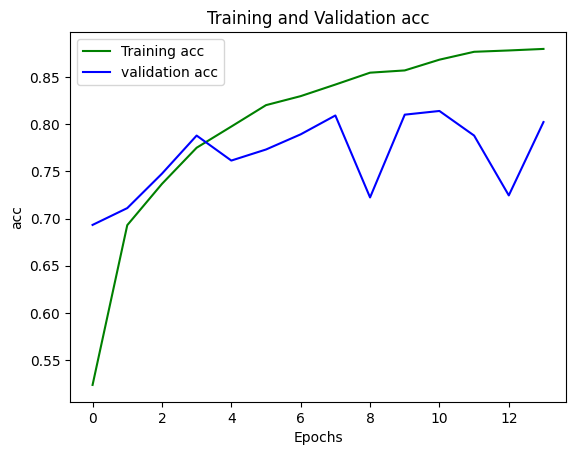

In [20]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,14)
plt.plot(epochs, loss_train, 'g', label='Training acc')
plt.plot(epochs, loss_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

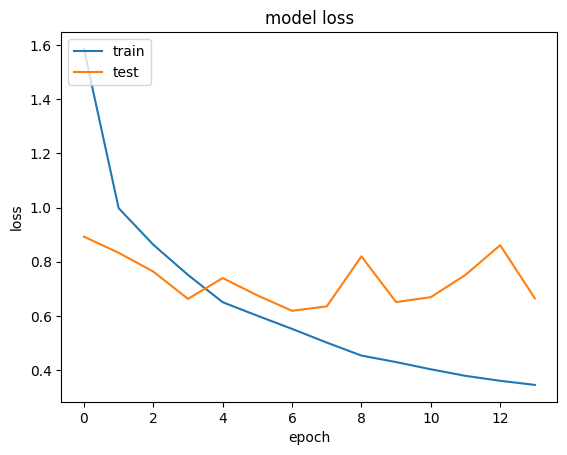

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.save('/content/drive/MyDrive/Echo_KVAK/model.h5')
model_json = model.to_json()
with open("/content/drive/MyDrive/Echo_KVAK/model.json", "w") as json_file:
  json_file.write(model_json)

#Explanation for sudden accuracy drops:
https://stackoverflow.com/questions/60691599/sudden-drop-in-validation-accuracy-during-training

In [ ]:
epoch = 30
loss_value = float('inf')

train_accuracy = []
validation_accuracy = []
train_loss = []
validation_loss = []

for e in range(epoch):
  train_results = np.empty(shape = (0, 7))
  validation_results = np.empty(shape = (0, 7))
  train_targets = np.empty(shape = (0, 7))
  validation_targets = np.empty(shape = (0, 7))
  for inputs, targets in train_generator:
      with tf.GradientTape() as tape:
          predictions = model(inputs)

          train_results = np.concatenate((train_results, predictions))
          train_targets = np.concatenate((train_targets, targets))

          prev_loss = loss_value
          loss_value = wcc(predictions, targets)

      gradients = tape.gradient(loss_value, model.trainable_weights)
      if (tf.math.reduce_sum(loss_value).numpy() < tf.math.reduce_sum(prev_loss).numpy()):
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
      else:
        loss_value = prev_loss

  metric.update_state(train_results, train_targets)
  train_acc = metric.result().numpy()
  train_ls = loss_value

  train_accuracy.append(train_acc)
  train_loss.append(train_ls)

  for inputs, targets in validation_generator:
    with tf.GradientTape() as tape:

      predictions = model(inputs)
      validation_result = np.concatenate((validation_results, predictions))
      validation_targets = np.concatenate((validation_targets, targets))

      loss_value = wcc(predictions, targets)

  metric.update_state(validation_results, validation_targets)
  validation_acc = metric.result().numpy()
  validation_ls = loss_value

  validation_accuracy.append(validation_acc)
  validation_loss.append(validation_ls)

  print(f'train_accuracy: {train_acc}, train_loss: {train_ls} || validation_accuracy: {validation_acc}, validation loss: {validation_ls}')

In [ ]:
epochs = range(0,30)
plt.plot(epochs, train_accuracy, 'g', label='Training acc')
plt.plot(epochs, validation_accuracy, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()